In [282]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [761]:
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from scipy.stats.mstats import gmean

In [318]:
dl = DataLib("SignalData")
country_codes = dl.pull('LongRates').columns
bond_return_index = dl.pull('BondRetIdx/LocalFX')

In [608]:
rf_rates = dl.pull('RFrates').divide(100)
daily_rf_rates = (rf_rates + 1).pow(1/261)-1
daily_rf_rates = daily_rf_rates.resample('B').ffill()

rf_rate_matrix = pd.DataFrame(0, index=bond_return_index.index, 
                              columns=bond_return_index.columns)
for country in country_codes:
    rf_rate_matrix[country] = daily_rf_rates


# Profit and Loss Curve

In [1274]:
def pnl_curve(signals):
    daily_signals = signals.resample("B").ffill()
    #long_signals = pd.DataFrame(1, index=daily_signals.index,
                               #columns=daily_signals.columns)
    
    bond_daily_returns = bond_return_index.pct_change() - rf_rate_matrix
    lagged_returns = bond_daily_returns.shift(-1)

    sig_returns = (lagged_returns * daily_signals)
    cum_sig_returns = (1+sig_returns).cumprod()
    sig_pct = (cum_sig_returns-1)*100
    
    #long_returns = (lagged_returns * long_signals)
    #cum_long_returns = (1+long_returns).cumprod()
    #long_pct = (cum_long_returns-1)*100
    
    for country in country_codes:
        sig_pct[country].dropna().rolling(60).mean().plot()
        #long_pct[country].plot()
        plt.title(country + ' Returns')
        plt.ylabel('Return Percentage')
        plt.show()
    
    sig_pct.sum(axis=1).plot()
    plt.title('Total Returns')
    plt.ylabel('Return Percentage')
    plt.show()

# Sharpe Ratio

In [1077]:
def sharpe_ratio(signals):
    
    daily_signals = signals.resample("B").ffill()
    
    bond_daily_returns = bond_return_index.pct_change() - rf_rate_matrix 
    lagged_returns = bond_daily_returns.shift(-1)

    returns = (lagged_returns * daily_signals) 
    
    country_SR = pd.Series(float(), index=country_codes)
    
    for country in country_codes:
        country_returns = returns[country].dropna()
        gmean_returns = gmean(1+country_returns)
        overall_return = (gmean_returns)**(261)-1
        overall_risk = country_returns.std()*np.sqrt(261)
        country_SR[country] = overall_return/overall_risk
    
    gmean_returns = gmean(1+returns.sum(axis=1))
    overall_return = (gmean_returns)**(261)-1
    overall_risk = returns.sum(axis=1).std()*np.sqrt(261)
    
    country_SR['OVERALL'] = (overall_return/overall_risk)
    
    return(country_SR)

# Plot Variables vs. Bond Returns for Each Country

In [1256]:
# do I want to compare to current bond returns or future bond returns?

def plot_vs_returns(df, string, var_window=1):
    bond_return_index = dl.pull('BondRetIdx/LocalFX')
    bond_daily_returns = bond_return_index.pct_change()
    bond_monthly_returns = bond_daily_returns.resample('M').mean()
    bond_monthly_returns = bond_monthly_returns.shift(-1)
    
    for country in country_codes:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(df[country].to_timestamp().rolling(var_window).mean(), color='blue', 
                 label = string)
        ax2.plot(bond_monthly_returns[country].to_timestamp()
         .rolling(60).mean(),color='magenta', label = 'bond returns')
        plt.title(country + ' ' + string + ' vs. Bond Returns')

# Curve Height

When using curve height as an indicator, it's most important to judge the different curve heights relative to other countries in a given year, since curve height is representative of international opportunity cost and will drive flows between different countries. Secondly, curve height should be measured based on its value relative to other countries, rather than its change over time. Our best indicator will tell us where a country's curve height lies relative to other countries, rather than whether it is increasing or decreasing, because its relative value is what will drive investors to buy or sell in different countries, causing prices to either rise or fall in the future.

To calculate our indicator, first, we'll calculate curve height as an average of long and short rates.

In [957]:
long_rates = dl.pull('LongRates')
short_rates = dl.pull('ShortRates')

curve_height = (long_rates+short_rates)/2
curve_height.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,0.4490,-0.5615,0.5040,0.2885,-0.2510,0.9795,-0.0635,-0.4605,0.2145,0.4345
2020-05,0.5590,-0.6725,0.4275,0.3120,-0.3555,1.1510,-0.0920,-0.5950,0.1415,0.4210
2020-06,0.5865,-0.5230,0.4090,0.0900,-0.2650,0.9060,-0.0780,-0.5710,0.1155,0.4100
2020-07,0.6020,-0.5300,0.4065,0.0090,-0.3270,0.7250,-0.0450,-0.5235,0.0750,0.4230
2020-08,0.5745,-0.6105,0.3655,-0.0185,-0.4105,0.5265,-0.0540,-0.6630,0.0130,0.3390


As discussed above, relative curve heights are important when determining opportunity cost between different countries. To relativize the curve heights in each year, I calculated a simple moving global average that incorporates values from the last five years and subtracted it from each value, to show how each country's curve height compared to the global average (in absolute terms). I then standardized within countries so that the mean and standard deviation within each country was 0 and 1, respectively.

In [816]:
global_avgs = curve_height.mean(axis=1)
CH_sma_5Y = global_avgs.rolling(60).mean()

relative_CH = curve_height.sub(CH_sma_5Y,axis=0)
standardized_CH = (relative_CH-relative_CH.mean())/relative_CH.std()
standardized_CH.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,-0.911156,0.150009,0.018706,-0.419740,-0.157544,-0.158720,1.638340,1.057515,-0.300431,0.336167
2020-05,-0.841569,0.068705,-0.041773,-0.394633,-0.253155,-0.047099,1.626729,0.931063,-0.364888,0.334103
2020-06,-0.818775,0.199794,-0.047694,-0.548331,-0.148505,-0.189728,1.643821,0.967930,-0.379326,0.334916
2020-07,-0.801222,0.206259,-0.036219,-0.596675,-0.196493,-0.291393,1.675272,1.031783,-0.405782,0.356244
2020-08,-0.809340,0.151824,-0.061613,-0.606991,-0.268006,-0.404727,1.678164,0.902896,-0.456129,0.302412


I then created a trading signal from these Z-scores by dividing each Z-score by 2, and then clipping it. This ensures that whenever relative curve heights are at least 2 standard deviations above or below average, we will be 100% long or 100% short. 

In [1249]:
CH_signals = standardized_CH.divide(2).clip(-1,1)
CH_signals.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,-0.455578,0.075005,0.009353,-0.209870,-0.078772,-0.079360,0.819170,0.528758,-0.150216,0.168084
2020-05,-0.420784,0.034352,-0.020886,-0.197317,-0.126577,-0.023550,0.813365,0.465532,-0.182444,0.167051
2020-06,-0.409387,0.099897,-0.023847,-0.274165,-0.074253,-0.094864,0.821910,0.483965,-0.189663,0.167458
2020-07,-0.400611,0.103129,-0.018109,-0.298337,-0.098246,-0.145696,0.837636,0.515892,-0.202891,0.178122
2020-08,-0.404670,0.075912,-0.030807,-0.303495,-0.134003,-0.202363,0.839082,0.451448,-0.228064,0.151206


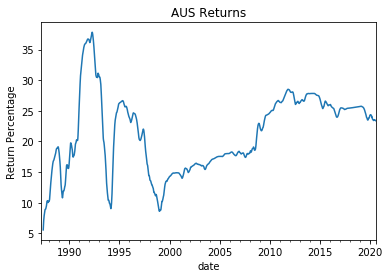

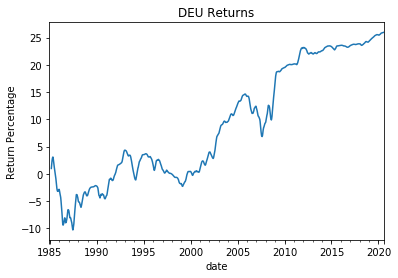

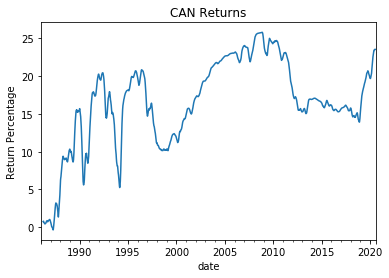

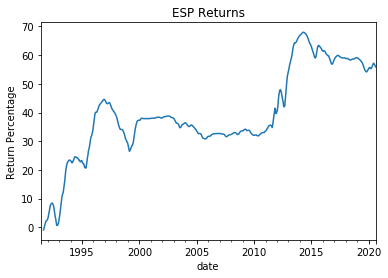

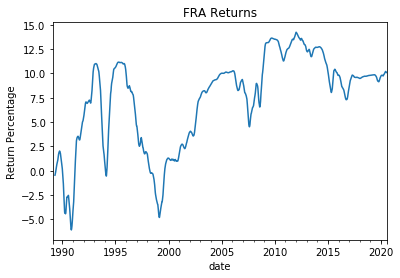

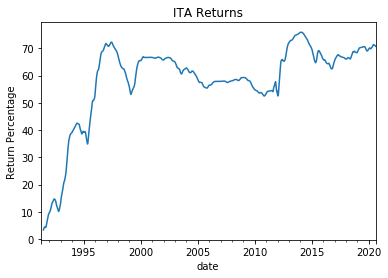

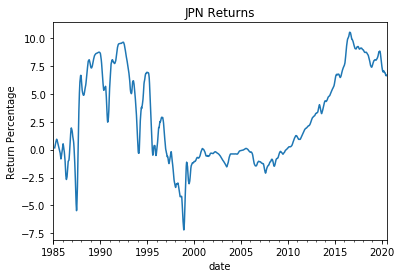

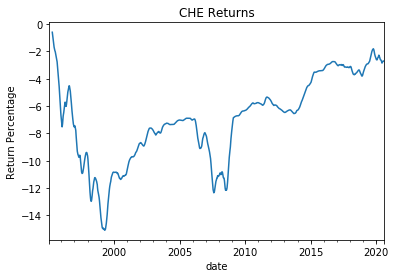

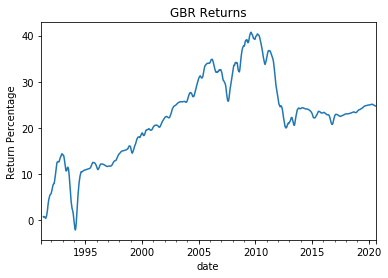

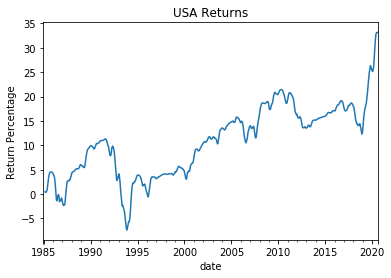

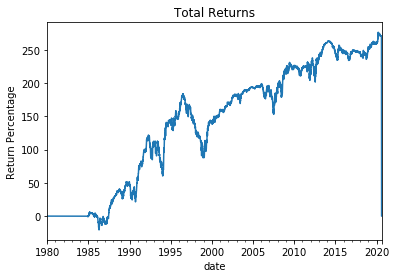

In [1276]:
pnl_curve(CH_signals)

In [1275]:
sharpe_ratio(CH_signals)

country
AUS        0.171714
DEU        0.252617
CAN        0.179844
ESP        0.387237
FRA        0.109024
ITA        0.469337
JPN        0.071685
CHE       -0.042757
GBR        0.250267
USA        0.255718
OVERALL    0.417822
dtype: float64

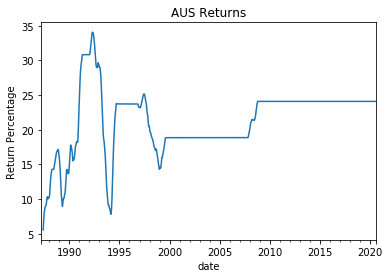

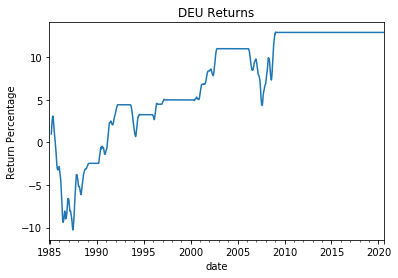

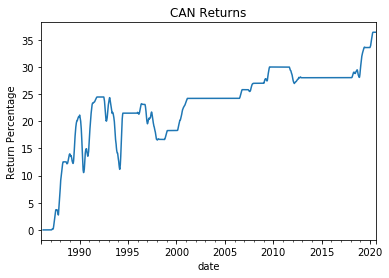

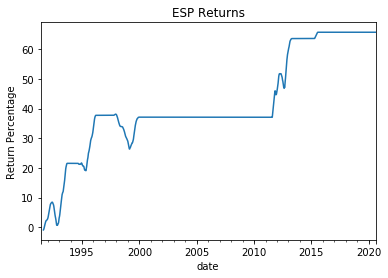

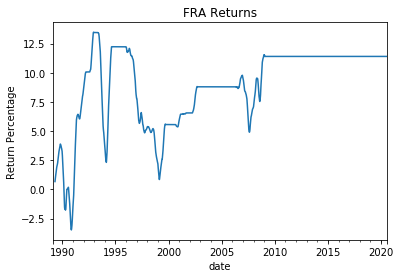

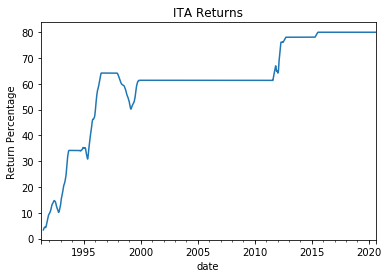

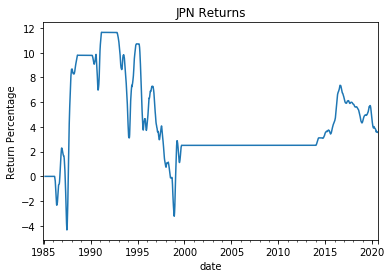

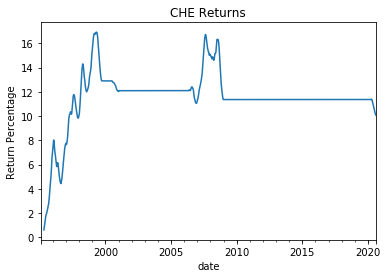

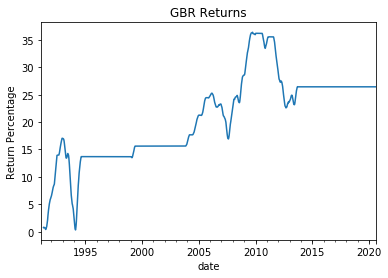

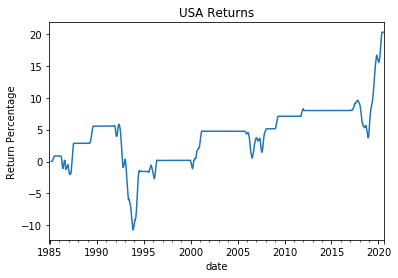

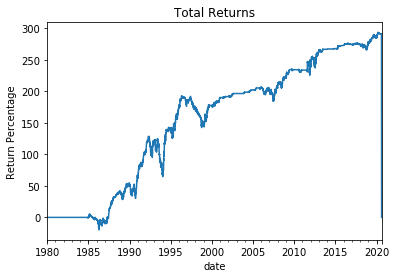

In [1287]:
CH_signals = standardized_CH.divide(2).clip(-1,1)

# Don't trade at Z-scores between -1 and 1
CH_signals[np.abs(CH_signals)<.5]=0

# Invert Switzerland signal
CH_signals['CHE'] = -1*CH_signals['CHE']
pnl_curve(CH_signals)

In [1288]:
sharpe_ratio(CH_signals)

country
AUS        0.201921
DEU        0.145808
CAN        0.294971
ESP        0.495345
FRA        0.137637
ITA        0.584096
JPN        0.044712
CHE        0.178293
GBR        0.300197
USA        0.190348
OVERALL    0.594091
dtype: float64

# Change in GDP

In [56]:
RGDP = dl.pull("GDP/Real")
RGDP_QOQ = RGDP.pct_change()
RGDP_QOQ.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2019Q3,0.005546,0.003093,0.002792,0.004047,0.001579,0.000052,0.000038,0.004400,0.005116,0.006369
2019Q4,0.005209,-0.000187,0.001397,0.004104,-0.001856,-0.002286,-0.018566,0.003379,-0.000001,0.005862
2020Q1,-0.003060,-0.020186,-0.021089,-0.052090,-0.059396,-0.053805,-0.005586,-0.026071,-0.021872,-0.012627
2020Q2,0.000000,-0.100915,0.000000,-0.184840,-0.138151,-0.123579,0.000000,0.000000,0.000000,-0.094947
2020Q3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [436]:
global_avg_1Y = RGDP_QOQ.rolling(4).mean().mean(axis=1)

# how is it doing relative to the global avg over the past year?
relative_growth = (RGDP_QOQ.sub(global_avg_1Y, axis=0))

# how does that relative performance compare to the country's relative performance
# over the past 6 years?
standardized_rel_growth = (relative_growth.rolling(24).
                           mean()-relative_growth)/relative_growth.rolling(24).std()

standardized_rel_growth.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2019Q3,-0.162717,0.020193,0.206482,0.592392,0.427115,0.454541,0.178985,-0.266310,-0.587815,-0.354600
2019Q4,-0.390337,0.563263,0.261830,0.320589,1.250388,1.210953,2.367752,-0.183993,1.141713,-0.470302
2020Q1,-0.345125,2.662708,2.712163,4.579798,4.548078,4.585810,-0.414715,3.698291,3.833893,2.685574
2020Q2,-3.998989,4.475454,-3.088173,4.486879,4.224126,4.224901,-2.958562,-3.132933,-3.566540,4.614701
2020Q3,-3.039866,-1.514345,-2.608964,-0.815700,-1.137121,-1.325946,-2.484606,-2.616152,-2.836033,-1.507105


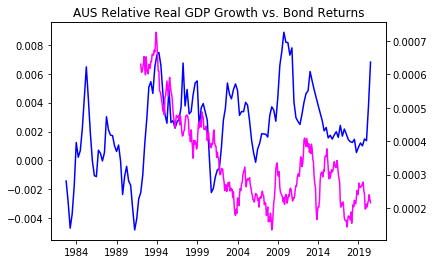

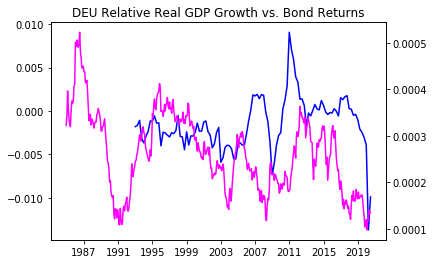

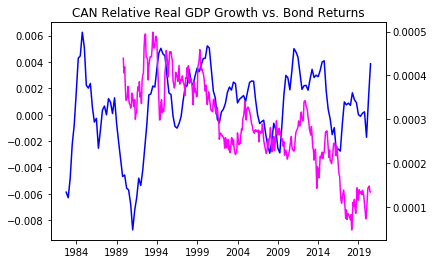

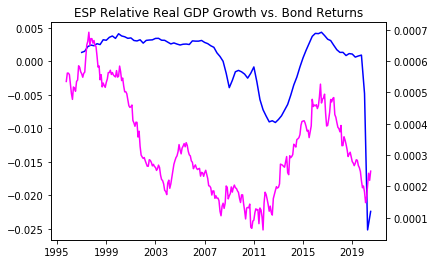

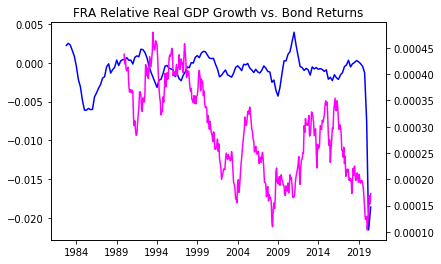

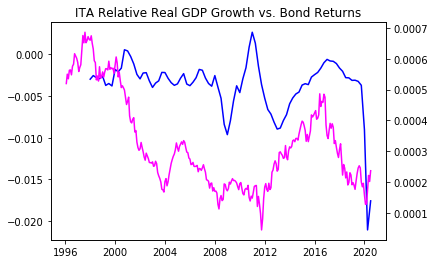

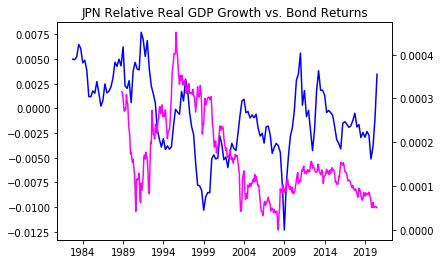

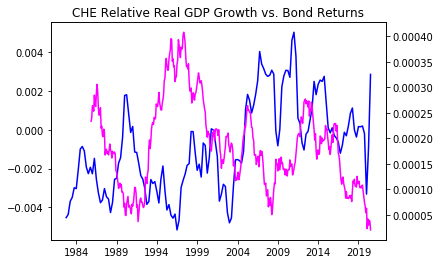

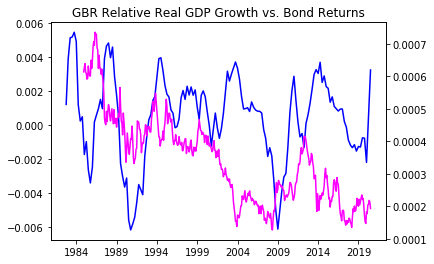

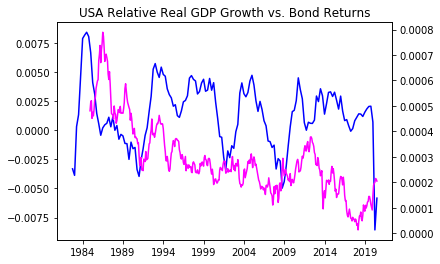

In [1257]:
plot_vs_returns(relative_growth, 'Relative Real GDP Growth', 8)

In [1258]:
GDP_signals = standardized_rel_growth.divide(2).clip(-1,1)
GDP_signals[np.abs(GDP_signals) < .5] = 0
GDP_signals.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2019Q3,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2019Q4,0.0,0.000000,0.0,0.0,0.625194,0.605477,1.0,0.0,0.570857,0.000000
2020Q1,0.0,1.000000,1.0,1.0,1.000000,1.000000,0.0,1.0,1.000000,1.000000
2020Q2,-1.0,1.000000,-1.0,1.0,1.000000,1.000000,-1.0,-1.0,-1.000000,1.000000
2020Q3,-1.0,-0.757172,-1.0,0.0,-0.568560,-0.662973,-1.0,-1.0,-1.000000,-0.753552


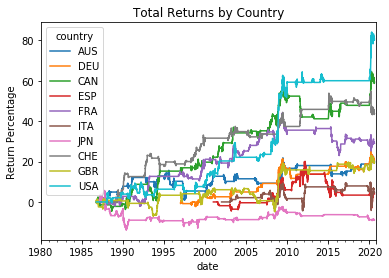

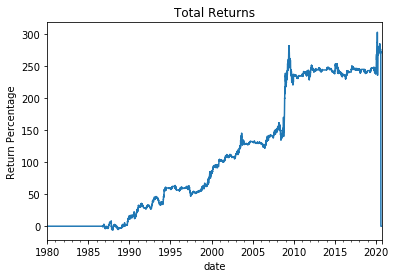

In [1259]:
pnl_curve(GDP_signals)

In [1260]:
GDP_signals['JPN'] = GDP_signals['JPN']*-1
sharpe_ratio(GDP_signals)

country
AUS        0.188145
DEU        0.322875
CAN        0.456006
ESP        0.049980
FRA        0.283197
ITA        0.061147
JPN        0.103474
CHE        0.434817
GBR        0.189935
USA        0.511266
OVERALL    0.498066
dtype: float64

# Combining Indicators

**Naive Combination Method**

In [1289]:
rs_GDP_signals = GDP_signals.resample('M').ffill()
signals = .5*CH_signals + .5*rs_GDP_signals
sharpe_ratio(signals)

country
AUS        0.270031
DEU        0.382633
CAN        0.470845
ESP        0.214347
FRA        0.326747
ITA        0.166613
JPN        0.088476
CHE        0.362000
GBR        0.324735
USA        0.505759
OVERALL    0.589359
dtype: float64

**Setting Low Signals to Zero**

In [1293]:
signals = .5*CH_signals + .5*rs_GDP_signals
signals[np.abs(signals)<.2] = 0
sharpe_ratio(signals)

country
AUS        0.264636
DEU        0.370786
CAN        0.475410
ESP        0.214347
FRA        0.333021
ITA        0.166613
JPN        0.077593
CHE        0.380024
GBR        0.327143
USA        0.505174
OVERALL    0.589459
dtype: float64

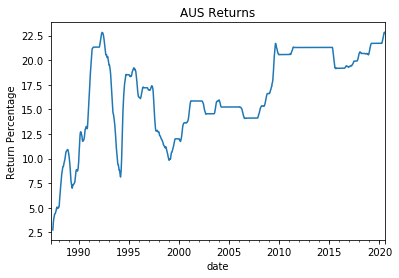

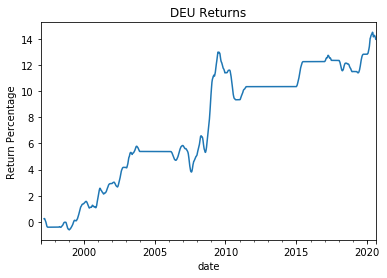

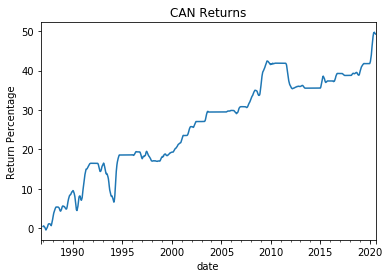

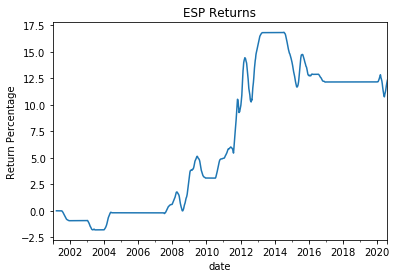

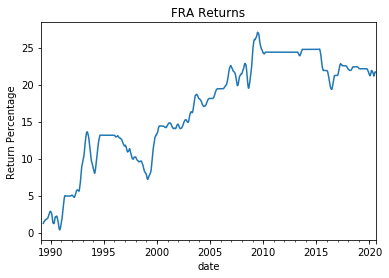

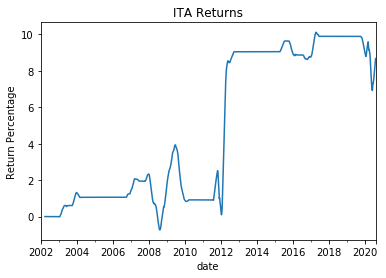

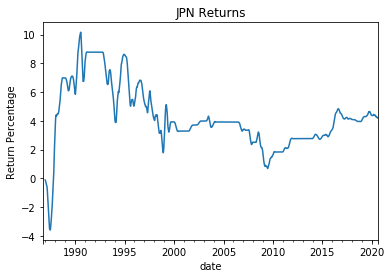

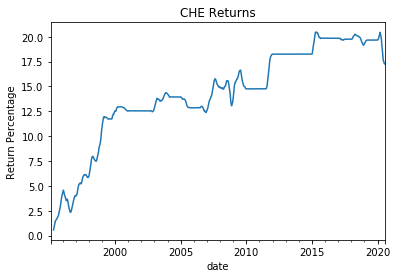

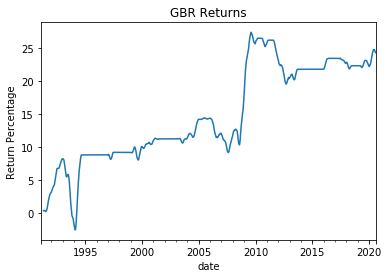

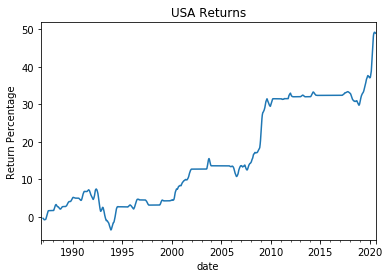

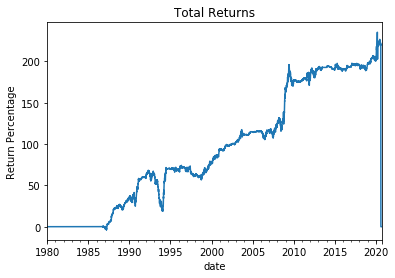

In [1294]:
pnl_curve(signals)

# Consumer Price Index (need to work on this one more)

In [729]:
CPI = dl.pull('CoreCPI/SA')
CPI_change = CPI.pct_change()
inf_exp = CPI_change.rolling(60).mean()
inf_exp_change = inf_exp.pct_change()

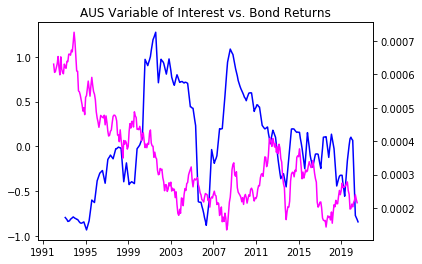

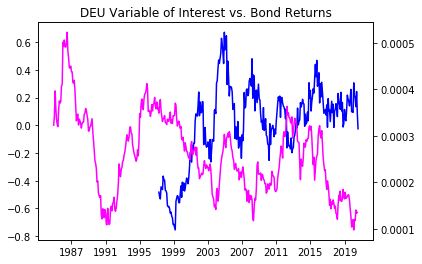

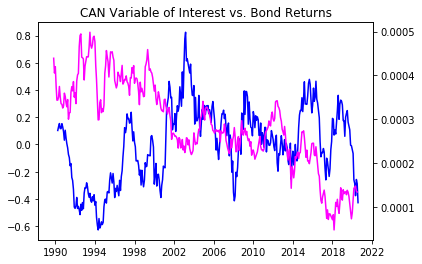

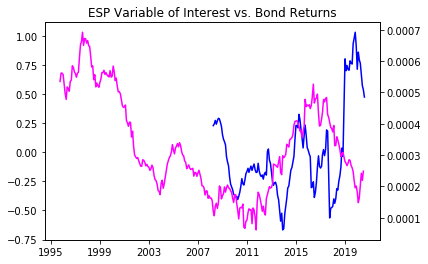

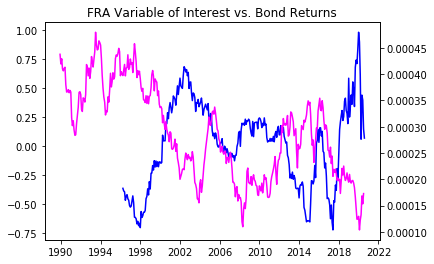

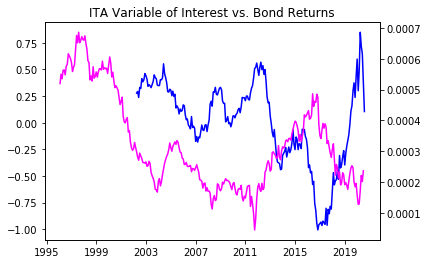

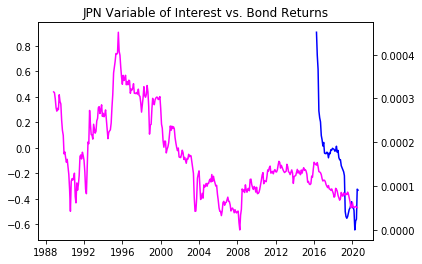

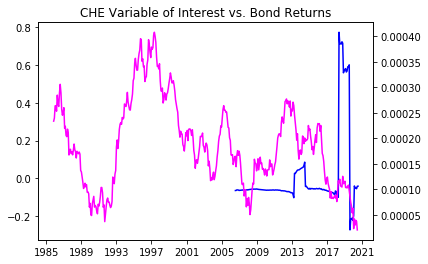

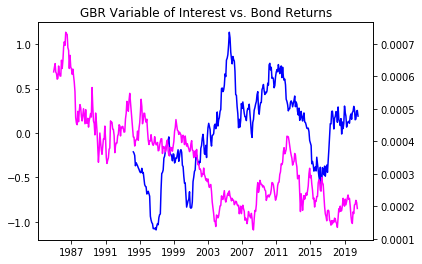

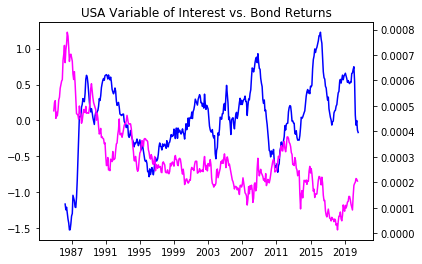

In [735]:
plot_vs_returns(norm_inf, 15)

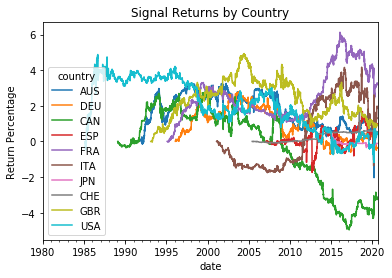

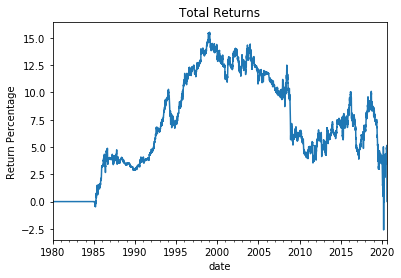

In [739]:
# need to look at this
norm_inf = (inf_exp_change.mean()-inf_exp_change)/inf_exp_change.std()
inf_signals = norm_inf.divide(10).clip(-1,1)
pnl_curve(inf_signals)


In [740]:
sharpe_ratio(inf_signals)

1.5824601813908838

# Bond Premium

In [1153]:
bp = long_rates - short_rates

global_avg_1Y = bp.rolling(24).mean().mean(axis=1)

# how is it doing relative to the global avg over the past year?
relative_bp = (bp.sub(global_avg_1Y, axis=0))

# how does that relative performance compare to the country's relative performance
# over the past 6 years?
standardized_rel_bp = (relative_bp - relative_bp.rolling(24).
                           mean())/relative_bp.rolling(24).std()

standardized_rel_bp.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,2.303020,-0.806032,3.070826,-0.373124,-0.438953,-1.076434,2.324370,0.390594,0.513447,2.605674
2020-05,3.095214,-0.705021,2.639864,-0.290749,-0.416264,-0.609445,2.073483,-0.253620,0.811266,2.466256
2020-06,2.417326,-0.157482,2.580428,0.280925,-0.359782,-0.912754,2.139516,0.718905,1.106154,2.407753
2020-07,2.287326,-0.025836,2.212621,0.390727,0.009786,-0.497680,2.041269,1.127017,1.434056,2.151427
2020-08,1.783787,-0.292614,1.876352,-0.457293,-0.452791,-0.795372,1.755295,1.321929,0.791439,1.721983


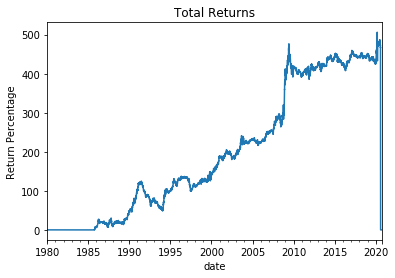

In [1154]:
pnl_curve(standardized_rel_bp.clip(-1,1))

In [1155]:
sharpe_ratio(standardized_rel_bp.clip(-1,1))

country
AUS        0.039402
DEU       -0.121159
CAN       -0.037280
ESP       -0.027579
FRA       -0.040932
ITA        0.037609
JPN        0.158924
CHE       -0.040285
GBR       -0.099225
USA        0.004264
OVERALL   -0.086745
dtype: float64